In [1]:
import random
import healpy as hp
import glob
from scipy.optimize import curve_fit
import pickle
from importlib import reload
import time
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import pylab
from pylab import arange, show, cm
from astropy import units as uq
import gc
from astropy.io import fits

### Specific qubic modules
from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import pysm3
import qubic
from qubic import QubicSkySim as qss
from qubic import NamasterLib as nam

import ComponentSeparation


### Some initializations, to be replaced with specific path, or to modify in bash
os.environ['QUBIC_DATADIR'] = '/home/mathias/Bureau/qubic/qubic'
os.environ['QUBIC_DICT'] = '/home/mathias/Bureau/qubic/qubic/dicts'
global_dir = Qubic_DataDir(datafile='instrument.py', datadir=os.environ['QUBIC_DATADIR'])

### Qubic dictionaries for 150GHz and 220Ghz
config_150, config_220 = 'FI-150', 'FI-220'
dictfilename150 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_150)
dictfilename220 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_220)
d150, d220 = qubic.qubicdict.qubicDict(), qubic.qubicdict.qubicDict()
d150.read_from_file(dictfilename150)
d220.read_from_file(dictfilename220)
qub_dic = {'150': d150, '220': d220}
center = qubic.equ2gal(d220['RA_center'], d220['DEC_center'])

def give_me_freqs_fwhm(dic, Nb) :
    band = dic['filter_nu'] / 1e9
    filter_relative_bandwidth = dic['filter_relative_bandwidth']
    a, nus_edge, nus_in, df, e, Nbbands_in = qubic.compute_freq(band, Nb, filter_relative_bandwidth)
    return nus_in, dic['synthbeam_peak150_fwhm'] * 150 / nus_in


def open_picklefile(directory, name, var) :

    """
    Open a pickle file from saved data
    """

    tab = pickle.load(open(directory + name, 'rb'))
    variable = tab[var]
    return variable

cov150 = open_picklefile('/home/mathias/Bureau/FG-Buster/', 'Coverage_dtheta_15_pointing_3000_{}.pkl'.format(d150['nside']), 'coverage')


def give_me_mask_apo(okpix = None, lmin = 2, lmax = 512, delta_ell = 16) :
    mask = np.zeros(12 * d150['nside']**2)
    mask[okpix] = 1
    # Namaster object
    Namaster = nam.Namaster(mask, lmin=2, lmax=512, delta_ell=16)
    apo = Namaster.mask_apo
    return apo

# Define okpix
okpix_inside = (cov150 > (0.5*np.max(cov150)))
okpix = (cov150 > (0.1*np.max(cov150)))

apo = give_me_mask_apo(okpix = okpix)

Definition that calculates the variance tables

In [2]:
def get_cov_weighted(dic, seed, noise, nsub, N, okpix, noise_profile, dust_only = False) :
    
    dic['nf_recon'] = nsub
    dic['nf_sub'] = nsub
    freqs, fwhmdegs = give_me_freqs_fwhm(dic, nsub)
    
    if dust_only == True :
        sky_config = {'dust': 'd0'}
    else :
        sky_config = {'cmb' : seed, 'dust': 'd0'}
    Qubic_sky = qss.Qubic_sky(sky_config, dic)
    
    maps_noise = np.zeros((((N, nsub, 3, np.sum(okpix)))))
    mat_cov = np.ones(((nsub, 3, np.sum(okpix))))
    
    for l in range(N) :
        
        print("real : {}".format(l))

        N, _ = Qubic_sky.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=noise, verbose=False, FWHMdeg=fwhmdegs, seed = None,
                                       spatial_noise=False,
                                       nunu_correlation=False, noise_only = True, noise_profile = noise_profile,
                                       integrate_into_band=False)
        
        N = np.transpose(N, (0, 2, 1))*apo
        #N, _, _ = ComponentSeparation.same_resol(N, fwhm_same, fwhm_target=None, verbose=False)
        maps_noise[l] = N[:, :, okpix]
    
    for i in range(3) :
        for j in range(nsub) :
            for k in range(np.sum(okpix)) :
                mat_cov[j, i, k] = np.var(maps_noise[:, j, i, k], axis = 0)
                
    return mat_cov, maps_noise

Definition which generate N maps with nsub sub-bands. You can activate or not the noise profile.

In [3]:
def give_me_all_maps(N, nsub, noise, noise_profile, spa_corr = False, nunu_corr = False, iib = False, dust_only = False) :
    
    all_maps_150 = np.zeros((((N, nsub, 3, 12*d150['nside']**2))))
    all_maps_noise_150 = np.zeros((((N, nsub, 3, 12*d150['nside']**2))))
    all_maps_220 = np.zeros((((N, nsub, 3, 12*d150['nside']**2))))
    all_maps_noise_220 = np.zeros((((N, nsub, 3, 12*d150['nside']**2))))

    all_maps_150_noiseless = np.zeros((((N, nsub, 3, 12*d150['nside']**2))))
    all_maps_220_noiseless = np.zeros((((N, nsub, 3, 12*d150['nside']**2))))

    for i in range(N) :
        seed = i+1
    
        if dust_only == True :
            sky_config = {'dust': 'd0'}
        else :
            sky_config = {'cmb' : seed, 'dust': 'd0'}
        #sky_config = {'dust': 'd0'}
        Qubic_sky_150 = qss.Qubic_sky(sky_config, d150)
        Qubic_sky_220 = qss.Qubic_sky(sky_config, d220)

        print("\n ============ ITERATION : {} ============ \n".format(i+1))

        freqs, fwhmdegs = give_me_freqs_fwhm(d150, nsub)
        fwhm_same = [np.max(fwhmdegs)]*nsub

        maps1_150, maps1_150_noiseless, N1_150, _ = Qubic_sky_150.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=noise, verbose=False, FWHMdeg=fwhm_same, seed = seed,
                                       spatial_noise=spa_corr,
                                       nunu_correlation=nunu_corr, noise_profile = noise_profile,
                                       integrate_into_band=iib)
        maps1_150 = np.transpose(maps1_150, (0, 2, 1))*apo
        maps1_150_noiseless = np.transpose(maps1_150_noiseless, (0, 2, 1))*apo
        N1_150 = np.transpose(N1_150, (0, 2, 1))*apo

        freqs, fwhmdegs = give_me_freqs_fwhm(d220, nsub)
        fwhm_same = [np.max(fwhmdegs)]*nsub

        maps1_220, maps1_220_noiseless, N1_220, _ = Qubic_sky_220.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=noise, verbose=False, FWHMdeg=fwhm_same, seed = seed,
                                       spatial_noise=spa_corr,
                                       nunu_correlation=nunu_corr, noise_profile = noise_profile,
                                       integrate_into_band=iib)
        maps1_220 = np.transpose(maps1_220, (0, 2, 1))*apo
        maps1_220_noiseless = np.transpose(maps1_220_noiseless, (0, 2, 1))*apo
        N1_220 = np.transpose(N1_220, (0, 2, 1))*apo

        all_maps_150[i] = maps1_150
        all_maps_220[i] =  maps1_220
        all_maps_150_noiseless[i] = maps1_150_noiseless
        all_maps_220_noiseless[i] =  maps1_220_noiseless
        all_maps_noise_150[i] = N1_150
        all_maps_noise_220[i] = N1_220
    
    return all_maps_150, all_maps_220, all_maps_150_noiseless, all_maps_220_noiseless, all_maps_noise_150, all_maps_noise_220

Several definitions for component separation...

In [4]:
def give_me_freqs_fwhm(dic, Nb) :
    band = dic['filter_nu'] / 1e9
    filter_relative_bandwidth = dic['filter_relative_bandwidth']
    a, nus_edge, nus_in, df, e, Nbbands_in = qubic.compute_freq(band, Nb, filter_relative_bandwidth)
    return nus_in, dic['synthbeam_peak150_fwhm'] * 150 / nus_in

def open_picklefile(directory, name, var) :

    """
    Open a pickle file from saved data
    """

    tab = pickle.load(open(directory + name, 'rb'))
    variable = tab[var]
    return variable

def give_me_mask_apo(okpix = None, lmin = 2, lmax = 512, delta_ell = 16) :
    mask = np.zeros(12 * d150['nside']**2)
    mask[okpix] = 1
    # Namaster object
    Namaster = nam.Namaster(mask, lmin=2, lmax=512, delta_ell=16)
    apo = Namaster.mask_apo
    return apo

def give_me_maps_combined(nsub, maps150, maps220) :
    
    freqs150, fwhmdegs150 = give_me_freqs_fwhm(d150, nsub)
    fwhm_final = np.max(fwhmdegs150) + 1e-5
    fwhm_same = [np.max(fwhmdegs150)]*nsub*2
    
    freqs220, fwhmdegs220 = give_me_freqs_fwhm(d220, nsub)
    fwhm_final = np.max(fwhmdegs220) + 1e-5
    
    maps = np.concatenate((maps150, maps220), axis = 1)
    freqs = list(freqs150) + list(freqs220)
    fwhm = list(fwhmdegs150) + list(fwhmdegs220)
    
    return maps, freqs, fwhm

The method is applied without noise profile. Both methods must give the same result

In [6]:
nside = 256
nsub = 3
ite = 10
noise = 3
profile = False
dust_only = False           # If True -> Only dust and noise components / If False -> CMB+Dust+Noise components 

# Read dictionary chosen
d150['focal_length'] = 0.3
d150['nside'] = nside

#Define the number of reconstruction bands:
d150['nf_recon'] = nsub
d150['nf_sub'] = nsub

# Read dictionary chosen
d220['focal_length'] = 0.3
d220['nside'] = nside

#Define the number of reconstruction bands:

d220['nf_recon'] = nsub
d220['nf_sub'] = nsub

npix = 12 * d150['nside'] ** 2
Nf = int(d150['nf_sub'])
band = d150['filter_nu'] / 1e9
filter_relative_bandwidth = d150['filter_relative_bandwidth']
npix = 12 * d220['nside'] ** 2
Nf = int(d220['nf_sub'])
band = d220['filter_nu'] / 1e9
filter_relative_bandwidth = d220['filter_relative_bandwidth']
a, nus_edge, nus_in, df, e, Nbbands_in = qubic.compute_freq(band, Nf, filter_relative_bandwidth)

cov150 = open_picklefile('/home/mathias/Bureau/FG-Buster/', 'Coverage_dtheta_15_pointing_3000_{}.pkl'.format(d150['nside']), 'coverage')

# Define okpix
okpix_inside = (cov150 > (0.5*np.max(cov150)))
okpix = (cov150 > (0.1*np.max(cov150)))

apo = give_me_mask_apo(okpix = okpix)

mat_cov150, _ = get_cov_weighted(d150, None, noise, nsub, ite, okpix_inside, noise_profile = profile, dust_only = dust_only)
mat_cov220, _ = get_cov_weighted(d220, None, noise, nsub, ite, okpix_inside, noise_profile = profile, dust_only = dust_only)
#mat_covcombined, _ = get_cov_weighted_combined(noise, nsub, ite, okpix_inside, noise_profile = profile)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/UinwACZ5SB
  warnings.warn(f"Access data from {full_path}")


real : 0
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 1
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 2
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 3
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 4
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 5
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSi

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/awUvLgz1OL
  warnings.warn(f"Access data from {full_path}")


real : 0
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 1
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 2
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 3
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 4
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 5
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSi

Visualisation of variance arrays

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


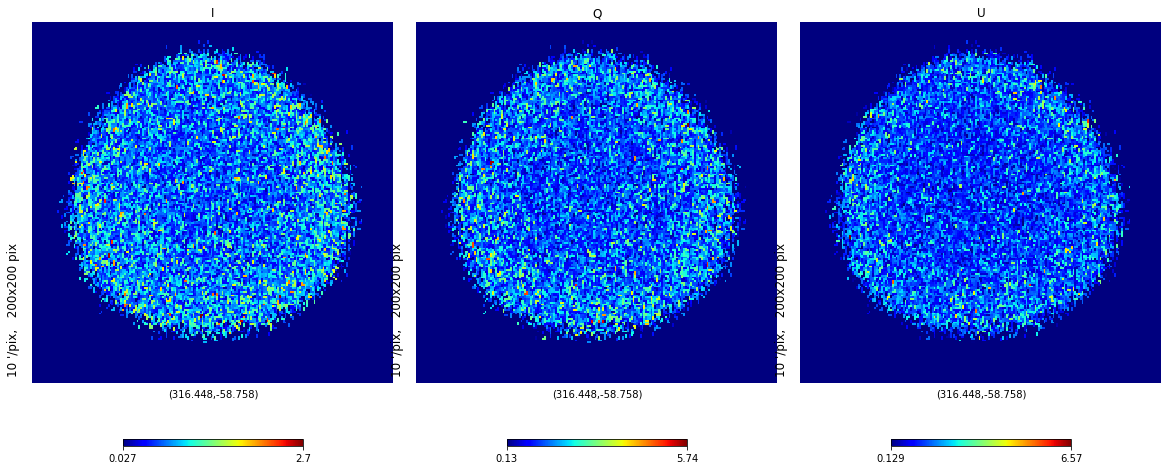

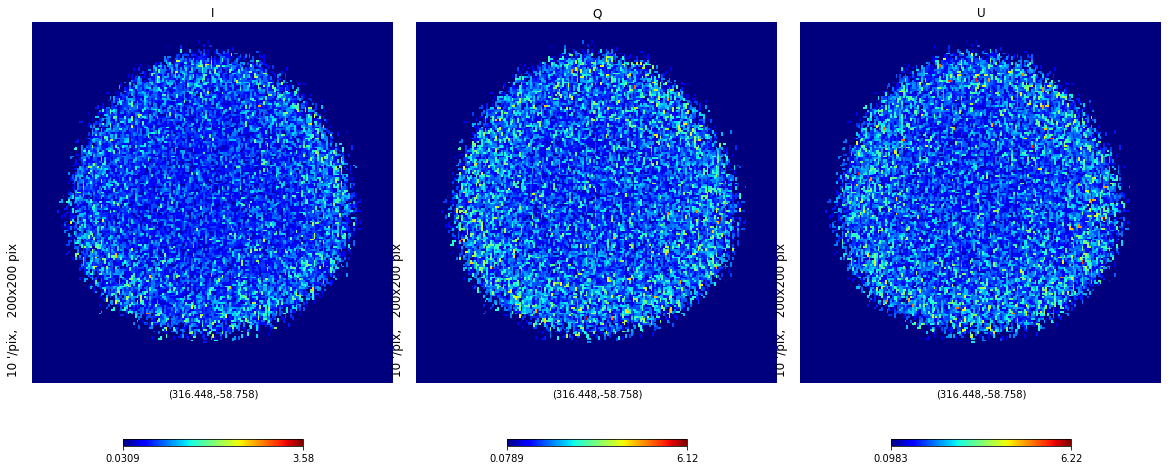

In [7]:
M = np.zeros(((nsub, 3, 12*nside**2)))
M[:, :, okpix_inside] = mat_cov150

plt.figure(figsize = (16, 10))
hp.gnomview(M[0, 0, :], rot = center, reso = 10, sub = (1, 3, 1), title = 'I', cmap = 'jet', min = np.min(M[0, 0, okpix_inside]), max = np.max(M[0, 0, okpix_inside]))
hp.gnomview(M[0, 1, :], rot = center, reso = 10, sub = (1, 3, 2), title = 'Q', cmap = 'jet', min = np.min(M[0, 1, okpix_inside]), max = np.max(M[0, 1, okpix_inside]))
hp.gnomview(M[0, 2, :], rot = center, reso = 10, sub = (1, 3, 3), title = 'U', cmap = 'jet', min = np.min(M[0, 2, okpix_inside]), max = np.max(M[0, 2, okpix_inside]))
plt.show()

M = np.zeros(((nsub, 3, 12*nside**2)))
M[:, :, okpix_inside] = mat_cov220

plt.figure(figsize = (16, 10))
hp.gnomview(M[0, 0, :], rot = center, reso = 10, sub = (1, 3, 1), title = 'I', cmap = 'jet', min = np.min(M[0, 0, okpix_inside]), max = np.max(M[0, 0, okpix_inside]))
hp.gnomview(M[0, 1, :], rot = center, reso = 10, sub = (1, 3, 2), title = 'Q', cmap = 'jet', min = np.min(M[0, 1, okpix_inside]), max = np.max(M[0, 1, okpix_inside]))
hp.gnomview(M[0, 2, :], rot = center, reso = 10, sub = (1, 3, 3), title = 'U', cmap = 'jet', min = np.min(M[0, 2, okpix_inside]), max = np.max(M[0, 2, okpix_inside]))
plt.show()

In [8]:
all_maps_150, all_maps_220, all_maps_150_noiseless, all_maps_220_noiseless, all_maps_noise_150, all_maps_noise_220 = give_me_all_maps(1,
                                                                                     nsub, 
                                                                                     noise, 
                                                                                     noise_profile = profile, dust_only = dust_only)

maps_combined, freqs_comb, fwhm_comb = give_me_maps_combined(nsub, all_maps_150, all_maps_220)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/GRB4vA8AuI
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/x0I1Ly3M32
  warnings.warn(f"Access data from {full_path}")



 ============ ITERATION : 1 ============ 

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>


In [9]:
reload(ComponentSeparation)

freqs, fwhmdegs = give_me_freqs_fwhm(d150, nsub)
print(freqs)
fwhm_same = [np.max(fwhmdegs)]*nsub

print()
print("150 GHz : ")
print()

rcomb_wei1_150 = ComponentSeparation.CompSep(d150).weighted(map1 = all_maps_150[0],
                                                                cov = mat_cov150, 
                                                                freq = freqs, 
                                                                fwhmdeg = fwhm_same, 
                                                                target = None, 
                                                                okpix = okpix_inside, 
                                                                Stokesparameter = 'IQU', dust_only = dust_only)


rcomb_150 = ComponentSeparation.CompSep(d150).fg_buster(map1=all_maps_150[0],
                                                        map_noise = all_maps_noise_150[0],
                                                        freq=freqs, 
                                                        fwhmdeg=fwhm_same, 
                                                        target = None, 
                                                        okpix = okpix_inside, 
                                                        Stokesparameter = 'IQU', dust_only = dust_only)
    
print()
print("220 GHz : ")
print()

freqs, fwhmdegs = give_me_freqs_fwhm(d220, nsub)
print(freqs)
fwhm_same = [np.max(fwhmdegs)]*nsub


rcomb_wei1_220 = ComponentSeparation.CompSep(d220).weighted(map1 = all_maps_220[0],
                                                                cov = mat_cov220, 
                                                                freq = freqs, 
                                                                fwhmdeg = fwhm_same, 
                                                                target = None, 
                                                                okpix = okpix_inside, 
                                                                Stokesparameter = 'IQU', dust_only = dust_only)


rcomb_220 = ComponentSeparation.CompSep(d220).fg_buster(map1=all_maps_220[0],
                                                        map_noise = all_maps_noise_220[0],
                                                        freq=freqs, 
                                                        fwhmdeg=fwhm_same, 
                                                        target = None, 
                                                        okpix = okpix_inside, 
                                                        Stokesparameter = 'IQU', dust_only = dust_only)
print("\n 150 GHz \n")
print("Weighted : ", rcomb_wei1_150.x)
print("Basic : ", rcomb_150.x)
print("Basic (sigma) : ", rcomb_150.Sigma)
print("Weighted (sigma) : ", rcomb_wei1_150.Sigma)
print("\n 220 GHz \n")
print("Weighted : ", rcomb_wei1_220.x)
print("Basic : ", rcomb_220.x)
print("Basic (sigma) : ", rcomb_220.Sigma)
print("Weighted (sigma) : ", rcomb_wei1_220.Sigma)

[136.98433698 148.95407944 161.96974246]

150 GHz : 

Importation of Qubic instrument..
Put the maps at the same angular resolution..
Give the right frequencies..
Perform component separation..
Shape :  (3, 3, 9776)
Shape :  (3, 3, 9776)


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:300: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freq
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:301: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdeg


Importation of Qubic instrument..
Put the maps at the same angular resolution..
Give the right frequencies and fwhm..
Give the rms of noise..
Perform component separation..


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:218: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freq
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:219: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdeg
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:224: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(map_noise, self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:225: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_p =


220 GHz : 

[200.9103609  218.46598318 237.55562228]
Importation of Qubic instrument..
Put the maps at the same angular resolution..
Give the right frequencies..
Perform component separation..
Shape :  (3, 3, 9776)
Shape :  (3, 3, 9776)


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:300: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freq
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:301: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdeg


Importation of Qubic instrument..
Put the maps at the same angular resolution..
Give the right frequencies and fwhm..
Give the rms of noise..
Perform component separation..


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:218: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freq
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:219: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdeg
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:224: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(map_noise, self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:225: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_p =


 150 GHz 

Weighted :  [1.86129638]
Basic :  [1.79927913]
Basic (sigma) :  [[0.00074848]]
Weighted (sigma) :  [[0.03319606]]

 220 GHz 

Weighted :  [1.55971802]
Basic :  [1.60752895]
Basic (sigma) :  [[8.21677954e-05]]
Weighted (sigma) :  [[0.00387094]]


In [10]:
nside = 256
nsub = 3
ite = 10
noise = 3
profile = True
dust_only = False

# Read dictionary chosen
d150['focal_length'] = 0.3
d150['nside'] = nside

#Define the number of reconstruction bands:
d150['nf_recon'] = nsub
d150['nf_sub'] = nsub

# Read dictionary chosen
d220['focal_length'] = 0.3
d220['nside'] = nside

#Define the number of reconstruction bands:

d220['nf_recon'] = nsub
d220['nf_sub'] = nsub

npix = 12 * d150['nside'] ** 2
Nf = int(d150['nf_sub'])
band = d150['filter_nu'] / 1e9
filter_relative_bandwidth = d150['filter_relative_bandwidth']
npix = 12 * d220['nside'] ** 2
Nf = int(d220['nf_sub'])
band = d220['filter_nu'] / 1e9
filter_relative_bandwidth = d220['filter_relative_bandwidth']
a, nus_edge, nus_in, df, e, Nbbands_in = qubic.compute_freq(band, Nf, filter_relative_bandwidth)

cov150 = open_picklefile('/home/mathias/Bureau/FG-Buster/', 'Coverage_dtheta_15_pointing_3000_{}.pkl'.format(d150['nside']), 'coverage')

# Define okpix
okpix_inside = (cov150 > (0.5*np.max(cov150)))
okpix = (cov150 > (0.1*np.max(cov150)))

apo = give_me_mask_apo(okpix = okpix)

mat_cov150, maps_noise = get_cov_weighted(d150, None, noise, nsub, ite, okpix_inside, noise_profile = profile, dust_only = dust_only)
mat_cov220, maps_noise = get_cov_weighted(d220, None, noise, nsub, ite, okpix_inside, noise_profile = profile, dust_only = dust_only)
#mat_covcombined, maps_noise = get_cov_weighted_combined(noise, nsub, ite, okpix_inside, noise_profile = profile)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/4gbSAsRUi6
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

real : 0
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 1
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 2
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 3
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 4
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_3.pkl'>
real : 5
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSi

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/JkvLSXXXt2
  warnings.warn(f"Access data from {full_path}")


real : 0
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 1
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 2
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 3
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 4
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_3.pkl'>
real : 5
<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSi

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


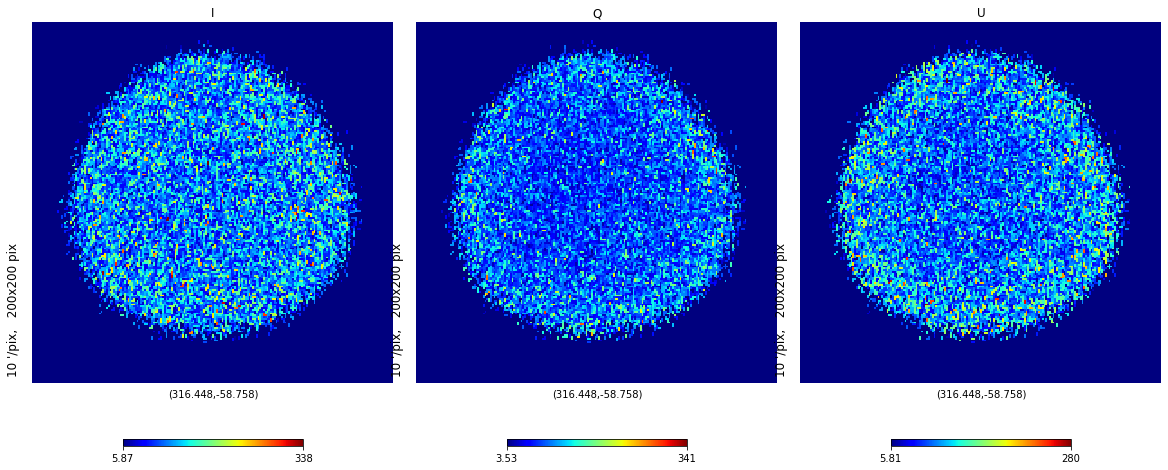

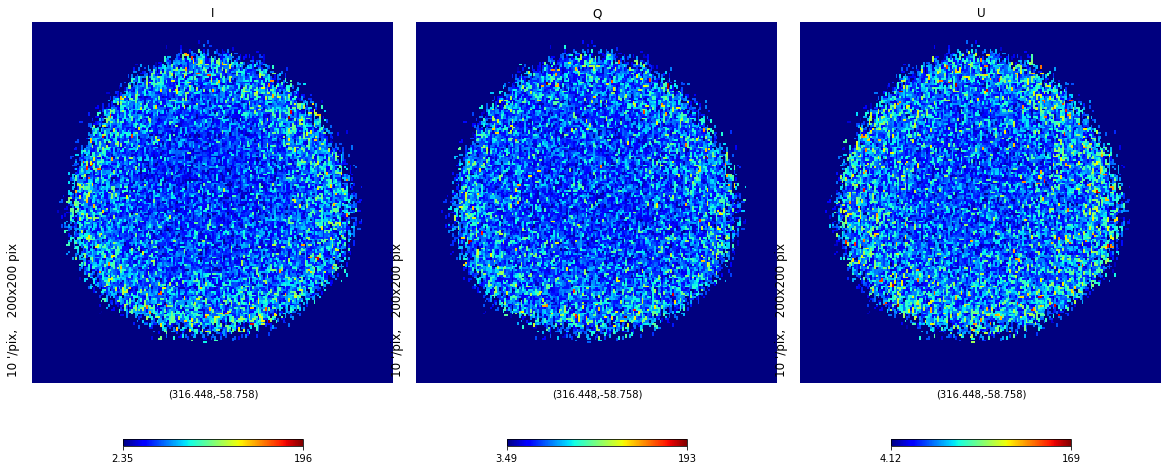

In [11]:
M = np.zeros(((nsub, 3, 12*nside**2)))
M[:, :, okpix_inside] = mat_cov150

plt.figure(figsize = (16, 10))
hp.gnomview(M[0, 0, :], rot = center, reso = 10, sub = (1, 3, 1), title = 'I', cmap = 'jet', min = np.min(M[0, 0, okpix_inside]), max = np.max(M[0, 0, okpix_inside]))
hp.gnomview(M[0, 1, :], rot = center, reso = 10, sub = (1, 3, 2), title = 'Q', cmap = 'jet', min = np.min(M[0, 1, okpix_inside]), max = np.max(M[0, 1, okpix_inside]))
hp.gnomview(M[0, 2, :], rot = center, reso = 10, sub = (1, 3, 3), title = 'U', cmap = 'jet', min = np.min(M[0, 2, okpix_inside]), max = np.max(M[0, 2, okpix_inside]))
plt.show()

M = np.zeros(((nsub, 3, 12*nside**2)))
M[:, :, okpix_inside] = mat_cov220

plt.figure(figsize = (16, 10))
hp.gnomview(M[0, 0, :], rot = center, reso = 10, sub = (1, 3, 1), title = 'I', cmap = 'jet', min = np.min(M[0, 0, okpix_inside]), max = np.max(M[0, 0, okpix_inside]))
hp.gnomview(M[0, 1, :], rot = center, reso = 10, sub = (1, 3, 2), title = 'Q', cmap = 'jet', min = np.min(M[0, 1, okpix_inside]), max = np.max(M[0, 1, okpix_inside]))
hp.gnomview(M[0, 2, :], rot = center, reso = 10, sub = (1, 3, 3), title = 'U', cmap = 'jet', min = np.min(M[0, 2, okpix_inside]), max = np.max(M[0, 2, okpix_inside]))
plt.show()

In [ ]:
freqs, fwhmdegs = give_me_freqs_fwhm(d150, nsub)
fwhm_same = [np.max(fwhmdegs)]*nsub
    
all_maps_150, all_maps_220, all_maps_150_noiseless, all_maps_220_noiseless, all_maps_noise_150, all_maps_noise_220 = give_me_all_maps(1,
                                                                                     nsub, 
                                                                                     noise, 
                                                                                     noise_profile = profile, 
                                                                                     dust_only = dust_only)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/XWblp8mD18
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/6kh58uKlge
  warnings.warn(f"Access data from {full_path}")



 ============ ITERATION : 1 ============ 



In [ ]:
reload(ComponentSeparation)

print()
print("150 GHz : ")
print()

freqs, fwhmdegs = give_me_freqs_fwhm(d150, nsub)
fwhm_same = [np.max(fwhmdegs)]*nsub

rcomb_wei1_150 = ComponentSeparation.CompSep(d150).weighted(map1 = all_maps_150[0],
                                                                cov = mat_cov150, 
                                                                freq = freqs, 
                                                                fwhmdeg = fwhm_same, 
                                                                target = None, 
                                                                okpix = okpix_inside, 
                                                                Stokesparameter = 'IQU', 
                                                                dust_only = dust_only)


rcomb_150 = ComponentSeparation.CompSep(d150).fg_buster(map1=all_maps_150[0],
                                                        map_noise = all_maps_noise_150[0],
                                                        freq=freqs, 
                                                        fwhmdeg=fwhm_same, 
                                                        target = None, 
                                                        okpix = okpix_inside, 
                                                        Stokesparameter = 'IQU', 
                                                        dust_only = dust_only)

    
print()
print("220 GHz : ")
print()

freqs, fwhmdegs = give_me_freqs_fwhm(d220, nsub)
fwhm_same = [np.max(fwhmdegs)]*nsub


rcomb_wei1_220 = ComponentSeparation.CompSep(d220).weighted(map1 = all_maps_220[0],
                                                                cov = mat_cov220, 
                                                                freq = freqs, 
                                                                fwhmdeg = fwhm_same, 
                                                                target = None, 
                                                                okpix = okpix_inside, 
                                                                Stokesparameter = 'IQU', dust_only = dust_only)


rcomb_220 = ComponentSeparation.CompSep(d220).fg_buster(map1=all_maps_220[0],
                                                        map_noise = all_maps_noise_220[0],
                                                        freq=freqs, 
                                                        fwhmdeg=fwhm_same, 
                                                        target = None, 
                                                        okpix = okpix_inside, 
                                                        Stokesparameter = 'IQU', dust_only = dust_only)

print("\n 150 GHz \n")
print("Weighted : ", rcomb_wei1_150.x)
print("Basic : ", rcomb_150.x)
print("Basic (sigma) : ", rcomb_150.Sigma)
print("Weighted (sigma) : ", rcomb_wei1_150.Sigma)
print("\n 220 GHz \n")
print("Weighted : ", rcomb_wei1_220.x)
print("Basic : ", rcomb_220.x)
print("Basic (sigma) : ", rcomb_220.Sigma)
print("Weighted (sigma) : ", rcomb_wei1_220.Sigma)